## Vector-valued function with Random Fourier Features

### Imports

In [15]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import time
from functools import wraps

### Runtime

In [16]:
def runtime(func):
    @wraps(func)
    def runtime_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print("\n", f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return runtime_wrapper

### Values

In [17]:
dimension = 2
sigma = 10
sigma2 = 2*sigma**2

# Random Fourier features
m = 20 # number of samples
w = np.array([randn(m) / sigma, randn(m) / sigma]) # w is the same size as the dimensions times the number of samples
b = np.random.rand(1, m)*2*np.pi # b is the same size as number of samples
n = 500 # number of points

x1 = randn(n)/2
x2 =  randn(n)/2
x_vector = np.array([x1, x2])
# x_vector = np.block([x1,x2])


noise = randn(n) * 1e-1
#y1 = np.cos(x1) + noise
#y2 = np.sin(x2) + noise

y1 = 1+np.sin(x1/10) + x1**2 + noise
y2 = 0.5 * x2**2 + np.exp(x2) + noise

y = np.array(np.ravel([y1, y2], 'F'))

lam = 0.000001 # Regularization parameter


### Gaussian Kernel

In [18]:
def k_gauss(x, z):
    k = np.exp(-((np.linalg.norm(x-z))**2)/(2*sigma**2))
    return k

def k_matrix(x, z, dim):
    k = k_gauss(x, z)
    k_matrix = k *np.eye(dim)
    return k_matrix

@runtime
def K_gauss(x, n, dim):
    K = np.zeros((dim*n, dim*n))
    for i in range(0, n):
        for j in range(0, n):
            k = k_gauss(x[:,i], x[:,j])
            K[i*dim][j*dim] = k
            K[i*dim+1][j*dim+1] = k
    return K

K = K_gauss(x_vector, n, dimension)



 Function K_gauss took 8.2969 seconds


#### Alpha

In [19]:
# Returns a vector with length dim * n
@runtime
def alpha(x, y, lam, n, dim):
    K = K_gauss(x, n, dim)
    alpha_vector = np.linalg.inv((K + lam*np.eye(dim*n))) @ y
    alpha_reshape = [alpha_vector[::2], alpha_vector[1::2]]
    return np.array(alpha_reshape)

alpha_ = alpha(x_vector, y, lam, n, dimension)



 Function K_gauss took 8.7639 seconds

 Function alpha took 8.9175 seconds


#### Estimated function

In [20]:
@runtime
def estimated_function(alpha, x, n, dim):
    function = np.zeros((2, n))
    for i in range(n):
        sum = np.zeros((2))
        x_i = x[:, i]
        for j in range(n):
            k = k_gauss(x_i, x[:, j])
            kernel = k*np.eye(dim)
            sum = sum + kernel@alpha[:, j]
        function[:, i] = sum 
    return function

func = estimated_function(alpha_, x_vector, n, dimension)


 Function estimated_function took 14.4641 seconds


#### Plot

C:\Users\vilde\AppData\Local\Temp\ipykernel_14540\4258807897.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\vilde\AppData\Local\Temp\ipykernel_14540\4258807897.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


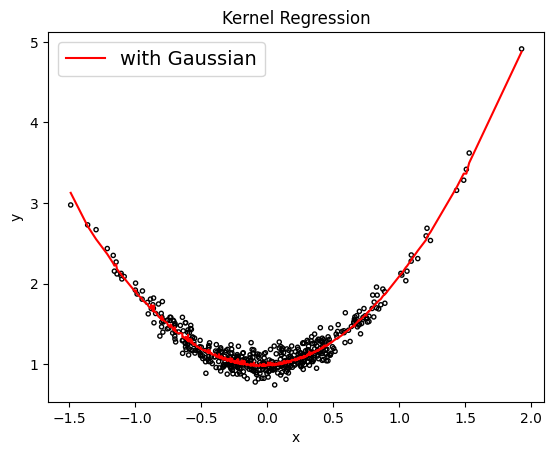

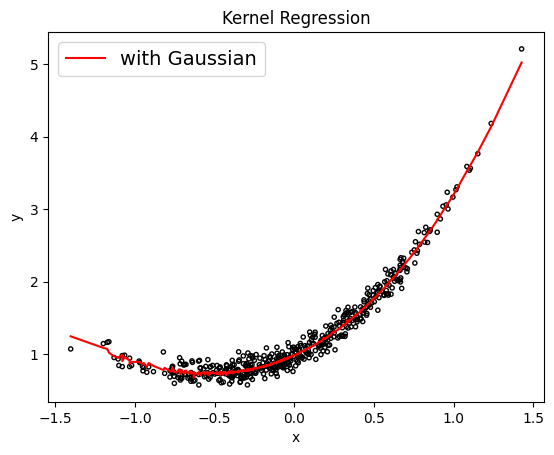

In [21]:
plt.style.use('default')

# Plot for x1 and y1
f1_sort = np.array([x for _,x in sorted(zip(x1,func[0]))])

f = plt.figure(1)
plt.scatter(x1,y1, facecolors ='none' , edgecolors = "k" , marker = ".")
plt.plot(np.sort(x1), f1_sort, c="r", label="with Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
f.show()

# Plot for x2 and y2
f2_sort = np.array([x for _,x in sorted(zip(x2,func[1]))])

g = plt.figure(2)
plt.scatter(x2,y2, facecolors ='none' , edgecolors = "k" , marker = ".")
plt.plot(np.sort(x2), f2_sort, c="r", label="with Gaussian")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
g.show()

### With Random Fourier Features

#### Psi

In [22]:
def psi(x, w, b):
    return np.sqrt(2) * np.cos(w.T@x + b)

def psi_vector(x, w, b, m):
    psi_vector = np.zeros(m)
    for i in range(m):
        psi_vector[i] = psi(x, w[:, i], b[:,i])
    return np.array(psi_vector)

def capital_psi(x, w, b, m, dim):
    psi = psi_vector(x,w,b,m)
    return np.kron(psi, np.eye(dim))

#### Phi

In [23]:
def phi(x, w, b, n, m, dim):
    phi = np.zeros((dim*n, dim*m))
    for i in range(0, n):
        psi = capital_psi(x[:,i], w, b, m, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

phi_ = phi(x_vector, w, b, n, m, dimension)

#### Alpha

In [24]:
def alpha_approx(x_vector, y, dim, m, lam, n):
    phi_ = phi(x_vector, w, b, n, m, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(dim*m))
    y_reshaped = np.reshape(y, (-1,1))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

alpha_approximation = alpha_approx(x_vector, y, dimension, m, lam, n)

#### Function Approximation

In [25]:
@runtime
def function_approximation(alpha, x, n, dim):
    f = np.zeros((dim, n))
    for i in range(n):
        f[:, [i]] = capital_psi(x[:, i], w, b, m, dim) @ alpha
    return f

function_estimate = function_approximation(alpha_approximation, x_vector, n, dimension)


 Function function_approximation took 0.3244 seconds


#### Plot

C:\Users\vilde\AppData\Local\Temp\ipykernel_14540\268464187.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\vilde\AppData\Local\Temp\ipykernel_14540\268464187.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


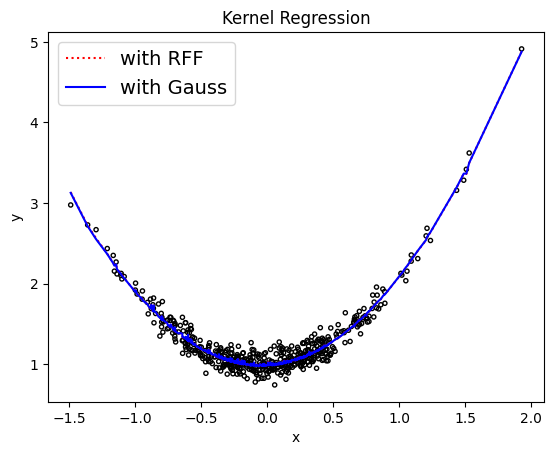

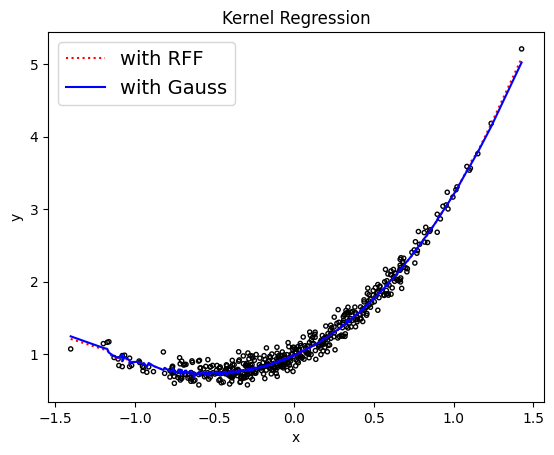

In [26]:
# Plot for x1 and y1
f1_sort_approx = np.array([x for _,x in sorted(zip(x1,function_estimate[0]))])

f = plt.figure(1)
plt.style.use('default')
plt.scatter(x1,y1, facecolors ='none' , edgecolors = "k" , marker = ".")
plt.plot(np.sort(x1), f1_sort_approx, c="r", label="with RFF", ls = ":")
plt.plot(np.sort(x1), f1_sort, c="b", label="with Gauss")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
f.show()

# Plot for x2 and y2
f2_sort_approx = np.array([x for _,x in sorted(zip(x2,function_estimate[1]))])

g = plt.figure(2)
plt.style.use('default')
plt.scatter(x2,y2, facecolors ='none' , edgecolors = "k" , marker = ".")
plt.plot(np.sort(x2), f2_sort_approx, c="r", label="with RFF", ls = ":")
plt.plot(np.sort(x2), f2_sort, c="b", label="with Gauss")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Kernel Regression")
plt.legend( loc = "upper left" , frameon = True , prop ={'size': 14 } )
g.show()